In [1]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    job_name="Climt2",          # --job-name
    cores=2,                     # Number of cores per task (adjust if needed)
    processes=1,                 # One process per task
    memory="20GB",               # --mem
    walltime="01:00:00",         # --time
    queue="med",               # --partition
    log_directory=".",           # Logs will be saved to the current directory
)

import glob 
import os

In [2]:
data_dir = '/home1/nalex2023/Datasets/interpsonde_manus/*.nc'

all_dsets = glob.glob(data_dir)

all_dsets

['/home1/nalex2023/Datasets/interpsonde_manus/2009_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2002_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2003_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2008_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2014_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2001_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2004_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2013_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2012_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2005_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2010_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2007_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2006_MANUS_INTERPSONDEv2.nc',
 '/home1/nal

In [3]:
from dask.distributed import Client
cluster.scale(jobs=4)
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.42.239.61:8787/status,
Dashboard: http://10.42.239.61:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.239.61:37325,Workers: 0
Dashboard: http://10.42.239.61:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
import xarray as xr 
import pandas as pd
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units

dset = xr.open_mfdataset(all_dsets, combine='by_coords').sel(time=slice('2012'))
dset['height'] = dset['height'] * 1000
dset['time'] = dset['time'].roll(time=10)

dset = dset.sortby('time')


In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from windrose import WindroseAxes


def create_dft(in_dir,arm_data=True):
    files = glob.glob(in_dir+os.sep+'*.nc')
    if len(files) == 0:
        files = glob.glob(in_dir+os.sep+'*.cdf')
        if len(files) == 0:
            raise Exception('No files Found')
        else:
            pass
    else:
        pass
    
    dft = pd.DataFrame(files,columns=['filepath'])
    dft['filename'] = dft['filepath'].str.split(os.sep).str[-1]
    
    if arm_data:
        dft['datetime'] = pd.to_datetime(dft['filename'].str.split(
            '.',
            expand=True).iloc[:, 2] + dft['filename'].str.split(
                '.',  expand=True).iloc[:, 3],format='%Y%m%d%H%M%S')


    return dft

In [6]:
#dset['u_wind'] = dset['u_wind'] - dset['u_wind'].mean(dim='time')
#dset['v_wind'] = dset['v_wind'] - dset['v_wind'].mean(dim='time')
dset

<xarray.Dataset> Size: 804MB
Dimensions:   (time: 100800, height: 332)
Coordinates:
  * height    (height) float32 1kB 4.0 24.0 44.0 ... 3.95e+04 4e+04 4.05e+04
  * time      (time) datetime64[ns] 806kB 2001-04-05 ... 2012-12-31T23:00:00
Data variables:
    bar_pres  (time, height) float32 134MB dask.array<chunksize=(8400, 332), meta=np.ndarray>
    temp      (time, height) float32 134MB dask.array<chunksize=(8400, 332), meta=np.ndarray>
    dp        (time, height) float32 134MB dask.array<chunksize=(8400, 332), meta=np.ndarray>
    rh        (time, height) float32 134MB dask.array<chunksize=(8400, 332), meta=np.ndarray>
    u_wind    (time, height) float32 134MB dask.array<chunksize=(8400, 332), meta=np.ndarray>
    v_wind    (time, height) float32 134MB dask.array<chunksize=(8400, 332), meta=np.ndarray>
Attributes: (12/13)
    command_line:          idl -D 0 -R -n interpolatedsonde -s twp -f C1 -b 2...
    Conventions:           ARM-1.1
    process_version:       vap-interpolatedsonde-6.6-0.el6
    input_datastreams:     twpgriddedsondeC1.c0 : 2.2 : 20010403.000030-20010...
    dod_version:           interpolatedsonde-c1-4.0
    site_id:               twp
    ...                    ...
    facility_id:           C1
    data_level:            c1
    location_description:  Tropical Western Pacific (TWP), Manus Island, Papu...
    datastream:            twpinterpolatedsondeC1.c1
    doi:                   10.5439/1095316
    history:               created by user ttoto on machine chalk at 2016-05-...

In [7]:
dset['angle'] = (90 - np.degrees(np.arctan2(-dset['u_wind'], -dset['v_wind']))) % 360



dset['speed'] = np.sqrt((dset['u_wind'] * dset['u_wind']) + 
                        (dset['v_wind'] * dset['v_wind']))

# remove the wind direction and speed if both u and v are 0
dset['angle'] = dset['angle'].where((dset['u_wind'] == 0) & (dset['v_wind'] == 0), dset['angle'])

dset['speed'] = dset['speed'].where((dset['u_wind'] == 0) & (dset['v_wind'] == 0), dset['speed'])



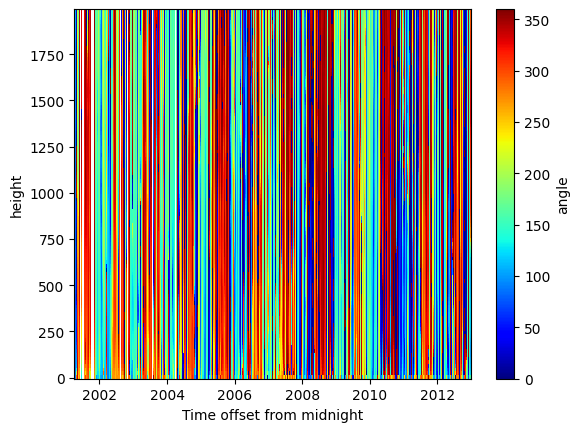

In [8]:
dset['angle'].sel(height=slice(0,2000)).plot(x='time',
                                          cmap='jet')

In [9]:
def draw_windrose(data,color=cm.Blues):
    ws = data['speed'].values
    wd = data['angle'].values
    ax = WindroseAxes.from_ax()
    ax.bar(wd,ws,normed=False,cmap=color)
    ax.set_legend()


def wind_rose_compare(data1,data2 ,cost_angle):
    ws1 = data1['speed'].values
    wd1 = data1['angle'].values
    ws2 = data2['speed'].values
    wd2 = data2['angle'].values
    
    ax = WindroseAxes.from_ax()
    
    ax.bar(wd1,ws1,normed=False,cmap=cm.Reds)
    ax.set_legend(loc='lower right')
    ax.bar(wd2,ws2,normed=False,cmap=cm.Blues)
    ax.set_legend(loc='lower left')

In [38]:
a  = dset.sel(height=10,method='nearest').compute()#.sel(hour=slice(12,19))

b = dset.sel(height=slice(500,2000)).compute()#.sel(hour=slice(12,19))

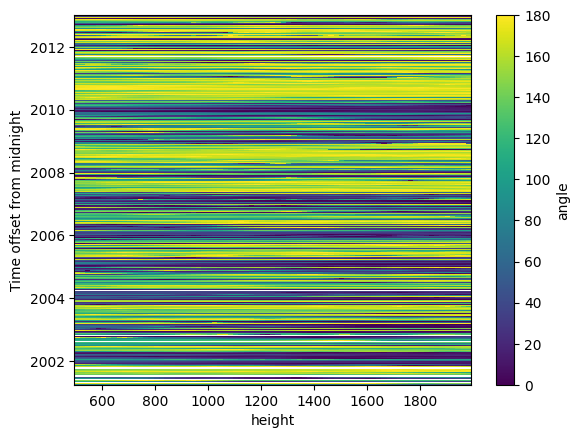

In [ ]:
cost_angle = 0


def ang_diff(angle1, angle2):
    diff = np.abs(angle1 - angle2)
    if diff > 180:
        diff = 360 - diff
    return diff



diff_a_coast = xr.apply_ufunc(
    ang_diff,
    a['angle'],
    cost_angle,
    input_core_dims=[[], []],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[np.float64],
)


diff_b_coast = xr.apply_ufunc(
    ang_diff,
    b['angle'],
    cost_angle + 180,
    input_core_dims=[[], []],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[np.float64],
)


a_within_90 = a.where(diff_a_coast > 90, drop=True)
b_within_180 = b.where(diff_b_coast > 90, drop=True)


#draw_windrose(a_within_90,color=cm.Reds)
#draw_windrose(b_within_180,color=cm.Blues)




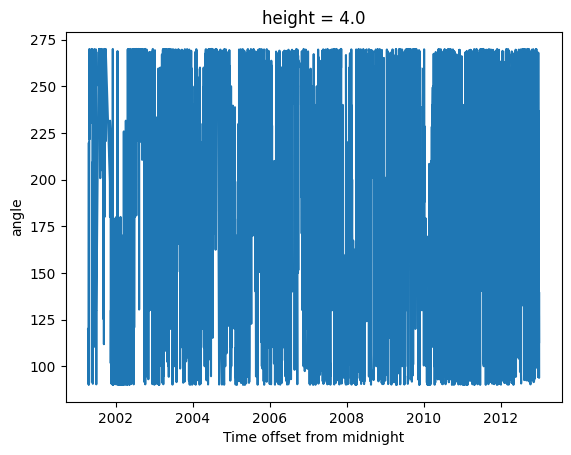

In [44]:
a_within_90['angle'].plot()

In [ ]:

def calc_SBI(a_within_90,b_within_180):
    SBI = np.cos(np.radians(a_within_90['angle'] - cost_angle)) * np.cos(a_within_90['angle'] + 180 - b_within_180['angle'])
    return SBI

SBI = xr.apply_ufunc(
    calc_SBI,
    a_within_90_expanded,  # (time, 1)
    b_within_180,  # (time, height)
    input_core_dims=[['time', 'height'], ['time', 'height']],  
    vectorize=True,
    dask='parallelized',
    output_dtypes=[np.float64],
    output_core_dims=[['time', 'height']],
)


#SBI = np.cos(np.radians(a_within_90['angle'] - cost_angle)) * np.cos(a_within_90['angle'] + 180 - b_within_180['angle'])

#SBI_diurnal = SBI.groupby('time.hour').sum(dim='time').compute()



In [52]:


b_within_180

<xarray.Dataset> Size: 168MB
Dimensions:   (time: 69690, height: 75)
Coordinates:
  * height    (height) float32 300B 504.0 524.0 544.0 ... 1.964e+03 1.984e+03
  * time      (time) datetime64[ns] 558kB 2001-04-05 ... 2012-12-31T23:00:00
Data variables:
    bar_pres  (time, height) float32 21MB 95.53 95.31 95.09 ... 80.73 80.54
    temp      (time, height) float32 21MB 24.76 24.57 24.46 ... 16.57 16.44
    dp        (time, height) float32 21MB 21.81 21.55 21.49 ... 13.01 12.85 12.7
    rh        (time, height) float32 21MB 84.97 84.61 84.86 ... 80.38 80.21
    u_wind    (time, height) float32 21MB -0.8424 -0.7208 ... -0.3625 -0.5509
    v_wind    (time, height) float32 21MB -1.177 -1.084 ... -0.3654 -0.3163
    angle     (time, height) float32 21MB 54.42 56.38 63.13 ... 68.4 45.23 29.86
    speed     (time, height) float32 21MB 1.448 1.302 1.201 ... 0.5147 0.6352
Attributes: (12/13)
    command_line:          idl -D 0 -R -n interpolatedsonde -s twp -f C1 -b 2...
    Conventions:           ARM-1.1
    process_version:       vap-interpolatedsonde-6.6-0.el6
    input_datastreams:     twpgriddedsondeC1.c0 : 2.2 : 20010403.000030-20010...
    dod_version:           interpolatedsonde-c1-4.0
    site_id:               twp
    ...                    ...
    facility_id:           C1
    data_level:            c1
    location_description:  Tropical Western Pacific (TWP), Manus Island, Papu...
    datastream:            twpinterpolatedsondeC1.c1
    doi:                   10.5439/1095316
    history:               created by user ttoto on machine chalk at 2016-05-...

In [29]:
SBI_diurnal = SBI[SBI > 0].groupby('time.hour').mean(dim='time').compute()



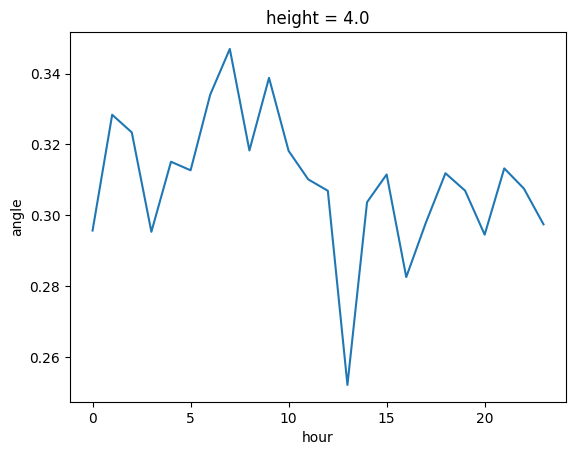

In [30]:
SBI_diurnal.plot()

In [31]:
met_fol = '/home1/nalex2023/Datasets/met_manus/'

met_dft = create_dft(met_fol,arm_data=True)

#met_dft_2012 = met_dft[met_dft['datetime'].dt.month.isin([4,5,6])][met_dft['datetime'].dt.year == 2012]

met_dft_2012 = met_dft[met_dft['datetime'].dt.year == 2012]

met_dft_2012

,filepath,filename,datetime
15,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20120904.000000.cdf,2012-09-04
21,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20120201.000000.cdf,2012-02-01
65,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20120912.000000.cdf,2012-09-12
85,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20120217.000000.cdf,2012-02-17
105,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20120928.000000.cdf,2012-09-28
...,...,...,...
6045,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20120511.000000.cdf,2012-05-11
6047,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20120818.000000.cdf,2012-08-18
6050,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20120720.000000.cdf,2012-07-20
6074,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20121130.000000.cdf,2012-11-30


In [32]:


dset_met_manus = xr.open_mfdataset(met_dft_2012['filepath'].values, combine='by_coords',chunks='auto')

In [33]:
surface_temp = dset_met_manus['temp_mean'].resample(time='1h').mean().roll(time=10)

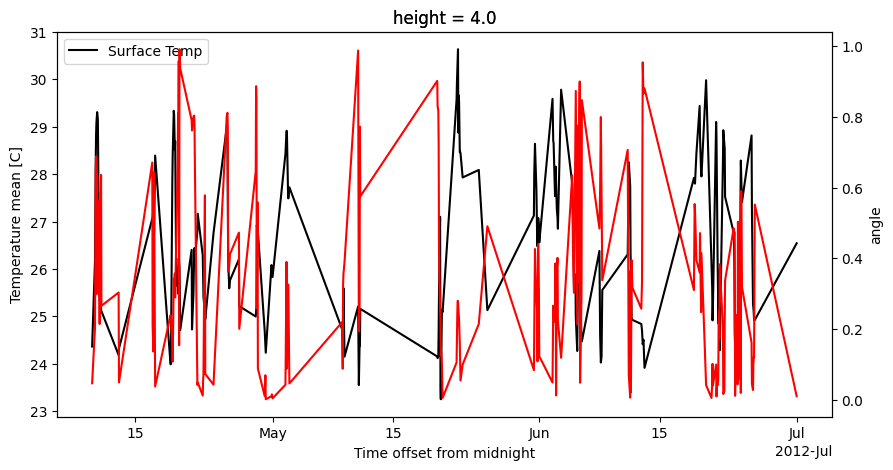

In [34]:
SBI_high = SBI.where(SBI > 0, drop=True).sel(time=slice('2012-04-01','2012-06-30'))

time_highs = SBI_high.time

#temp_surface = dset['temp'].sel(height=2,method='nearest').sel(time=time_highs).compute()
temp_surface = surface_temp.sel(time=time_highs,method='nearest').compute()

fig,ax = plt.subplots(1,1,figsize=(10,5))

temp_surface.plot(ax=ax, color='black', label='Surface Temp')

ax2 = ax.twinx()

SBI_high.plot(ax=ax2, color='red', label='SBI > 0.8')

ax.legend(loc='upper left')

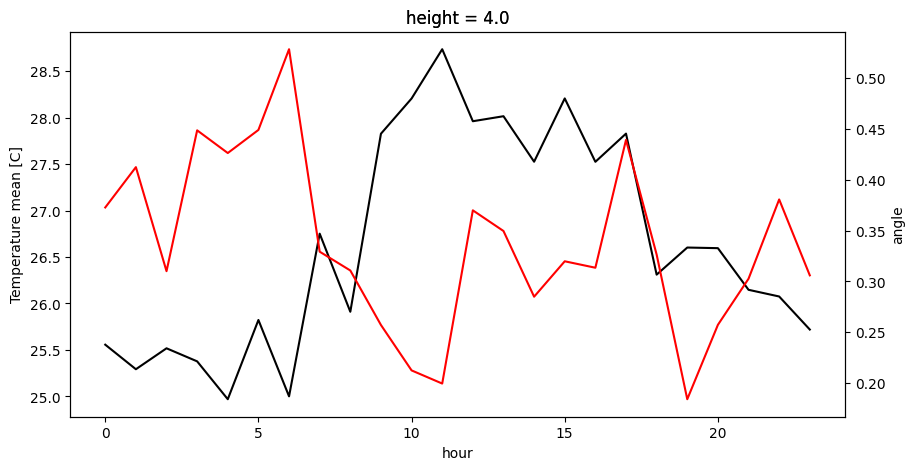

In [35]:
diurnal_surf_temp = temp_surface.groupby('time.hour').mean(dim='time').compute()

diurnal_sbi = SBI_high.groupby('time.hour').mean(dim='time').compute()


fig,ax = plt.subplots(1,1,figsize=(10,5))

ax2 = ax.twinx()

diurnal_surf_temp.plot(ax=ax, color='black', label='Surface Temp')

diurnal_sbi.plot(ax=ax2, color='red', label='SBI > 0.8')


new_dft = SBI_diurnal.to_dataframe().reset_index()


In [37]:
new_dft_diurnal = new_dft.set_index('hour')

temp_dft = diurnal_surf_temp.to_dataframe().reset_index().set_index('hour')

new_dft_diurnal['temp'] = temp_dft['temp_mean']

final_cols = new_dft_diurnal.drop(columns=['height'])

final_cols.corr()

,angle,temp
angle,1.000000,-0.239812
temp,-0.239812,1.000000


In [ ]:
# lead lag correlation 

